# Time series regressions
* This book demonstrates basic time series tests, which are a subset of the time-series tests discussed in class.
* I demonstrate the variance risk premium. For the homework you will analyze the G/P ratio.


In [ ]:
!pip install stargazer
!pip install FixedEffectModel

  Created wheel for FixedEffectModel: filename=FixedEffectModel-0.0.2-cp37-none-any.whl size=22434 sha256=cea1d0a72ca365b377e5355ed07ca883f2960f59716c101fe2bdba185a5fc57d
  Stored in directory: /root/.cache/pip/wheels/85/67/e4/e33b91f5f553822c72d6cfc9bec053cf17c1f14798afcfd11a
Successfully built FixedEffectModel


In [ ]:
import pandas as pd # data frames wrangling
import numpy as np # fast and vectorized math functions
import scipy as sp # scientific calculation toolkit
from sklearn.decomposition import PCA
import statsmodels.api as sm # statistical models including regression
import statsmodels.formula.api as smf
import os
from stargazer.stargazer import Stargazer
import FixedEffectModel.api as FEM
# import linearmodels as lm # linear models including panel OLS
import os # operating system operations like check files existance
import gc # garbage collector
import time # time related utility functions
import warnings
import matplotlib.pyplot as plt # MATLAB-like plotting library
plt.rcParams["figure.figsize"] = (10.5, 6)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"  # multiple output per jupyter notebook code block
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.simplefilter(action="ignore", category=pd.core.common.SettingWithCopyWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/data_lectures')

In [ ]:
# TSMOM metrics

tsmom = pd.read_excel(
    'Time Series Momentum Factors Monthly New.xlsx',
    sheet_name='TSMOM Factors', #time series momentum
    skiprows=17
)

tsmom.head()

,Date,TSMOM,TSMOM^CM,TSMOM^EQ,TSMOM^FI,TSMOM^FX
0,01/31/1985,0.043066,-0.014042,0.153376,-0.015625,0.056041
1,02/28/1985,0.038128,0.047449,0.043061,-0.193815,0.099316
2,03/29/1985,-0.052719,-0.083491,0.032803,0.071045,-0.117085
3,04/30/1985,0.039634,0.060051,0.024413,0.047500,0.019504
4,05/31/1985,0.063918,0.045516,0.121216,0.144524,0.020146


,TSMOM,TSMOM^CM,TSMOM^EQ,TSMOM^FI,TSMOM^FX
Date,,,,,
01/31/1985,0.043066,-0.014042,0.153376,-0.015625,0.056041
02/28/1985,0.082836,0.032740,0.203041,-0.206412,0.160922
03/29/1985,0.025750,-0.053484,0.242505,-0.150031,0.024995
04/30/1985,0.066405,0.003355,0.272838,-0.109658,0.044987
05/31/1985,0.134568,0.049024,0.427126,0.019018,0.066040


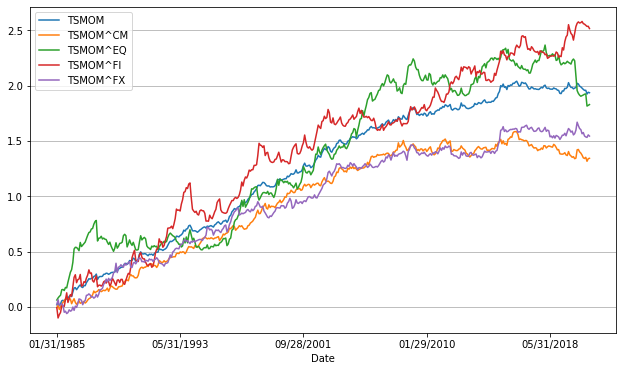

In [ ]:
plt.rcParams["figure.figsize"] = (10.5, 6)

((tsmom.set_index('Date', drop = True) + 1).cumprod() - 1).head()

ax = np.log10((tsmom.set_index('Date', drop = True) + 1).cumprod()).plot() #log10 scale flatts things 
ax.grid(axis='y')
#the back-test of this paper is credible
#green line is flat since financial crisis, fixed income market is the only except

'lets just subtract 25bps transaction cost at each step'

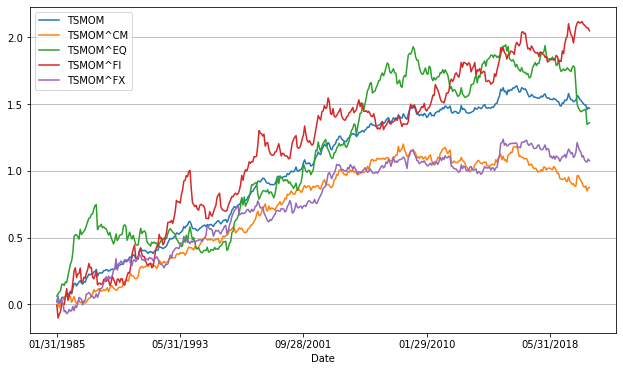

In [ ]:
'lets just subtract 25bps transaction cost at each step'

ax = np.log10((tsmom.set_index('Date', drop = True) + 1 - .0025).cumprod()).plot()
ax.grid(axis='y')

In [ ]:
def end_of_month(x):
    if not (isinstance(x, pd.Series)):
        return str((pd.to_datetime(x) + pd.tseries.offsets.MonthEnd(0)).date())
    return (pd.to_datetime(x) + pd.tseries.offsets.MonthEnd(0)).apply(lambda x: str(x.date()))

In [ ]:
ff4_file = 'ff_four_factor_monthly.parquet'

ff4=pd.read_parquet(ff4_file)

dta=ff4.index
ff4=ff4.reset_index()
ff4['date']=dta
ff4.head()

,date,mkt_rf,smb,hml,rf,mom
0,1926-07-31,0.028846,-0.022300,-0.028580,0.002252,0.000000
1,1926-08-31,0.026697,-0.013359,0.040830,0.002603,0.000000
2,1926-09-30,0.003724,-0.012803,-0.000864,0.002162,0.000000
3,1926-10-31,-0.033011,-0.000574,0.006766,0.003255,0.000000
4,1926-11-30,0.025847,-0.002349,-0.004590,0.003125,0.014084


In [ ]:


ff4 = (
    ff4
    .assign(date=lambda d: end_of_month(d['date']))
    .groupby('date')
    .apply(lambda d: d.apply(lambda s: (s+1).prod(skipna = False) - 1))
    .reset_index()
)
ff4.rename(columns = {'date': 'Date'}, inplace = True)
ff4.head()

tsmom['Date'] = tsmom['Date'].apply(end_of_month)

merged_mom = pd.merge(ff4, tsmom, on='Date')

merged_mom.head()

,Date,mkt_rf,smb,hml,rf,mom
0,1926-07-31,0.028846,-0.022300,-0.028580,0.002252,0.000000
1,1926-08-31,0.026697,-0.013359,0.040830,0.002603,0.000000
2,1926-09-30,0.003724,-0.012803,-0.000864,0.002162,0.000000
3,1926-10-31,-0.033011,-0.000574,0.006766,0.003255,0.000000
4,1926-11-30,0.025847,-0.002349,-0.004590,0.003125,0.014084


,Date,mkt_rf,smb,hml,rf,mom,TSMOM,TSMOM^CM,TSMOM^EQ,TSMOM^FI,TSMOM^FX
0,1985-01-31,0.079369,0.028996,-0.049145,0.006399,-0.064276,0.043066,-0.014042,0.153376,-0.015625,0.056041
1,1985-02-28,0.012077,0.005254,-0.004266,0.005715,0.006963,0.038128,0.047449,0.043061,-0.193815,0.099316
2,1985-03-31,-0.008269,-0.012258,0.041466,0.006108,0.018931,-0.052719,-0.083491,0.032803,0.071045,-0.117085
3,1985-04-30,-0.009539,0.001140,0.038108,0.007164,0.033393,0.039634,0.060051,0.024413,0.047500,0.019504
4,1985-05-31,0.050585,-0.021640,-0.008767,0.006621,0.044996,0.063918,0.045516,0.121216,0.144524,0.020146


In [ ]:
smf.ols(
    'TSMOM ~ mom',
    merged_mom
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TSMOM   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     79.28
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           1.66e-17
Time:                        02:25:51   Log-Likelihood:                 842.93
No. Observations:                 420   AIC:                            -1682.
Df Residuals:                     418   BIC:                            -1674.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0096      0.002      5.964      0.000       0.006       0.013
mom            0.3191      0.036      8.904      0.000       0.249       0.390
==============================================================================
Omnibus:                        2.175   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                2.187
Skew:                           0.016   Prob(JB):                        0.335
Kurtosis:                       3.352   Cond. No.                         22.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
smf.ols('TSMOM ~ mom+hml+smb+mkt_rf', merged_mom).fit().summary()

l1 = smf.ols('TSMOM ~ mom+hml+smb+mkt_rf', merged_mom).fit()
l2 = smf.ols('TSMOM ~ np.power(mom, 2)+mom+hml+smb+mkt_rf', merged_mom).fit()
l3 = smf.ols('TSMOM ~ np.power(mom, 2)+mom+hml+smb+mkt_rf+np.power(mkt_rf, 2)', merged_mom).fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TSMOM   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     21.95
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           1.90e-16
Time:                        02:25:53   Log-Likelihood:                 846.76
No. Observations:                 420   AIC:                            -1684.
Df Residuals:                     415   BIC:                            -1663.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0091      0.002      5.549      0.000       0.006       0.012
mom            0.3303      0.038      8.753      0.000       0.256       0.404
hml           -0.0814      0.059     -1.391      0.165      -0.196       0.034
smb           -0.0980      0.055     -1.797      0.073      -0.205       0.009
mkt_rf         0.0716      0.040      1.802      0.072      -0.006       0.150
==============================================================================
Omnibus:                        1.983   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.371   Jarque-Bera (JB):                1.931
Skew:                           0.025   Prob(JB):                        0.381
Kurtosis:                       3.328   Cond. No.                         39.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
'''
    COMMENT: this block of code displays regressions
'''

stargazer = Stargazer([l1, l2, l3])
stargazer

'\n    COMMENT: this block of code displays regressions\n'

In [ ]:
tsmom.head(20)


In [ ]:

pca = PCA()
pca.fit(tsmom[['TSMOM', 'TSMOM^CM', 'TSMOM^EQ', 'TSMOM^FX']].dropna())

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.explained_variance_ratio_
np.cumsum(pca.explained_variance_ratio_)
pd.DataFrame(np.transpose(pca.components_), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=['TSMOM', 'TSMOM^CM', 'TSMOM^EQ', 'TSMOM^FIH'])

array([0.58362983, 0.26548129, 0.13532978, 0.01555909])

array([0.58362983, 0.84911113, 0.98444091, 1.        ])

,PC1,PC2,PC3,PC4
TSMOM,-0.312736,0.329268,0.215777,0.864418
TSMOM^CM,-0.172151,0.398875,0.799965,-0.413907
TSMOM^EQ,-0.901726,-0.395567,-0.077622,-0.156180
TSMOM^FIH,-0.243826,0.758951,-0.554501,-0.238893


# implied realized gap
* I am going to use a file that documents the implied-realized gap in volatility predicts future stock returns


In [ ]:
# You may use this block of code to download the file
" THIS DOWNLOADS MY CLASS DEMONSTRATION FILE TO YOUR WORKING DIRECTORY"
vrp_data = 'vrp_class_demonstration.csv'



' THIS DOWNLOADS MY CLASS DEMONSTRATION FILE TO YOUR WORKING DIRECTORY'

In [ ]:
# Open the file
a = pd.read_csv(vrp_data)
a.head()

,date,vix,rvol
0,20000131,0.2495,0.189803
1,20000229,0.2337,0.182363
2,20000331,0.2411,0.210813
3,20000428,0.2620,0.287260
4,20000531,0.2365,0.216101


In [ ]:
# This is the VIX + realized volatility this month. We want to predict next month's market return.
# Step : get the market portfolio from somewhere. we have a file that has it
# the file is ff_four_factor

ff4_file='ff_four_factor.parquet'

mkt = (
    pd.read_parquet(ff4_file)
    .assign(trading_dt=lambda d: end_of_month(d['dt']))
    .groupby('trading_dt')
    .apply(lambda d: 
    pd.Series({
        'mkt_rf': (d['mkt_rf']+d['rf']+1).prod(skipna = False) - (d['rf']+1).prod(skipna = False)
    }))
           
    .reset_index()
)

In [ ]:
a['trading_dt'] = end_of_month((pd.to_datetime(a['date'].apply(str)) + pd.to_timedelta(15, unit='D'))\
    .apply(lambda x: (str(x.date()))))

In [ ]:
print('what the dataframe looks like now')
a.head()

what the dataframe looks like now


,date,vix,rvol,trading_dt
0,20000131,0.2495,0.189803,2000-02-29
1,20000229,0.2337,0.182363,2000-03-31
2,20000331,0.2411,0.210813,2000-04-30
3,20000428,0.2620,0.287260,2000-05-31
4,20000531,0.2365,0.216101,2000-06-30


In [ ]:
# forecasting regression
forecasting_dataset = pd.merge(mkt, a, on='trading_dt')
forecasting_dataset.head()

,trading_dt,mkt_rf,date,vix,rvol
0,2000-02-29,0.025435,20000131,0.2495,0.189803
1,2000-03-31,0.048878,20000229,0.2337,0.182363
2,2000-04-30,-0.064011,20000331,0.2411,0.210813
3,2000-05-31,-0.043800,20000428,0.2620,0.287260
4,2000-06-30,0.047064,20000531,0.2365,0.216101


In [ ]:
# let's create a variable called the implied realized gap
forecasting_dataset = forecasting_dataset.assign(implied_realized_gap=lambda d: d['vix']-d['rvol'])

# steps
1. look at the time-series predictor - does it vary a lot over time, covarying with important times in the stock market? ideally, a leading not a lagging indicator
1. run a simple time series regression $\frac{1}{horizon} \sum r_{mkt, t} -r_{f, t} = \alpha + \beta_1 s_{t-1}+\epsilon_t$
    * make sure its predictive e.g. no look ahead bias
    * ideally, check different horizons of predictability
1. run a rolling regression
    * plot the coefficients
    * out of sample R-squared

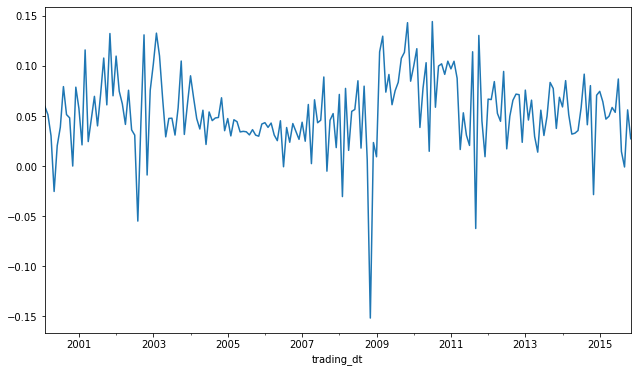

In [ ]:
# step #1 let's plot the implied / realized gap over time
# it looks stationary
plt.rcParams["figure.figsize"] = (10.5, 6)

ax = forecasting_dataset.assign(trading_dt=lambda d: pd.to_datetime(d['trading_dt']))\
    .set_index('trading_dt')['implied_realized_gap'].plot()

In [ ]:
# Okay, lets do a simple regression    
smf.ols('mkt_rf ~ implied_realized_gap', forecasting_dataset).fit().summary()

print()
print('{} is the standard deviation of the implied realized gap'.format(forecasting_dataset['implied_realized_gap'].std()))
print('{} is the percent change in market for a 1 standard deviation change in the\nimplied volatility minus realized gap'\
          .format(np.round(forecasting_dataset['implied_realized_gap'].std()*.316277*100, 2)))

#这里在复制ppt70页的做法，老师用了2007年之后的数据，得到的coef=0.3163，paper的coef=1.07

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 mkt_rf   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     14.39
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           0.000200
Time:                        02:29:37   Log-Likelihood:                 325.86
No. Observations:                 190   AIC:                            -647.7
Df Residuals:                     188   BIC:                            -641.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0134      0.005     -2.447      0.015      -0.024      -0.003
implied_realized_gap     0.3163      0.083      3.793      0.000       0.152       0.481
==============================================================================
Omnibus:                       18.375   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.936
Skew:                          -0.725   Prob(JB):                     2.84e-05
Kurtosis:                       3.735   Cond. No.                         26.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


0.03818385201123926 is the standard deviation of the implied realized gap
1.21 is the percent change in market for a 1 standard deviation change in the
implied volatility minus realized gap


# one possible interp of economic magnitude
$\beta * \sigma(x)$

In [ ]:
forecasting_dataset = forecasting_dataset.assign(implied_realized_gap_sq=lambda d: np.power(d['vix'], 2)-d['rvol'])
smf.ols('mkt_rf ~ implied_realized_gap_sq', forecasting_dataset).fit().summary()

NameError: ignored

In [ ]:
# sometimes, in some papers
# we look at the log return
# the predictor performs better because at a low frequency, market returns can have fat tails
smf.ols('np.log(mkt_rf+1) ~ implied_realized_gap_sq', forecasting_dataset).fit().summary()

NameError: ignored

# newey west adjustment
* when reporting the t-stat, the t-stat does not account for time-series autocorrelation
* time-series stock returns are sometimes autocorrelated
* sometimes this does not matter, sometimes it actually improves your results, sometimes it kills your results

In [ ]:
# newey west adjustment
# this is for the fact that at many horizons, returns are autocorrelated

l = smf.ols('mkt_rf ~ implied_realized_gap', forecasting_dataset)

l.fit(cov_type='HAC',cov_kwds={'maxlags':1}).summary().tables[1]
l.fit(cov_type='HAC',cov_kwds={'maxlags':4}).summary().tables[1]
l.fit(cov_type='HAC',cov_kwds={'maxlags':6}).summary().tables[1]

# In this particular case, accounting for this autocorrelation actually helped us

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0134,0.005,-2.447,0.014,-0.024,-0.003
implied_realized_gap,0.3163,0.088,3.579,0.000,0.143,0.490


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0134,0.005,-2.476,0.013,-0.024,-0.003
implied_realized_gap,0.3163,0.081,3.919,0.000,0.158,0.474


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0134,0.005,-2.463,0.014,-0.024,-0.003
implied_realized_gap,0.3163,0.082,3.849,0.000,0.155,0.477


In [ ]:
s = l.fit(cov_type='HAC',cov_kwds={'maxlags':1}).summary2().tables[1]

In [ ]:
# Rolling window - cumulative
N=30 # example windows size

keep = []
for i in range(N, len(forecasting_dataset)+1):
    a = smf.ols('np.log(mkt_rf+1) ~ implied_realized_gap', forecasting_dataset.iloc[:i]).fit()\
        .summary2().tables[1].loc['implied_realized_gap']
    
    a['dt'] = pd.to_datetime(forecasting_dataset.iloc[i-1]['trading_dt'])
    # save the regressions into an array
    keep.append(a)
    
keep = pd.DataFrame(keep).set_index('dt')
keep['lower'] = keep['Coef.'] - keep['Std.Err.']
keep['upper'] = keep['Coef.'] + keep['Std.Err.']

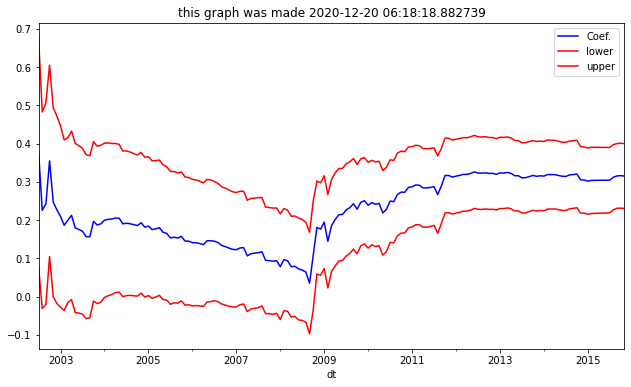

In [ ]:
# Make sure it doesn't look too big
ax = keep[['Coef.', 'lower', 'upper']].plot(
    title='this graph was made {}'.format(pd.Timestamp.today()),
    color=['blue', 'red', 'red']
)

# the above is a plot of$\beta $ from the regression

In [ ]:
# Rolling window - cumulative
N=30 # example windows size

keep = []
for i in range(N, len(forecasting_dataset)+1):
    a = smf.ols('np.log(mkt_rf+1) ~ implied_realized_gap', forecasting_dataset.iloc[i-30:i]).fit()\
        .summary2().tables[1].loc['implied_realized_gap']
    
    a['dt'] = pd.to_datetime(forecasting_dataset.iloc[i-1]['trading_dt'])
    # save the regressions into an array
    keep.append(a)
    
keep = pd.DataFrame(keep).set_index('dt')
keep['lower'] = keep['Coef.'] - keep['Std.Err.']
keep['upper'] = keep['Coef.'] + keep['Std.Err.']

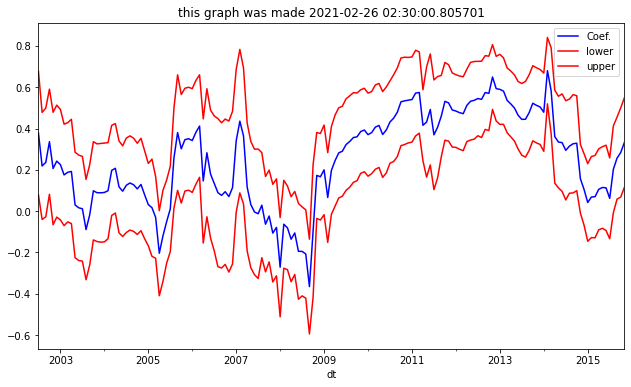

In [ ]:
# Make sure it doesn't look too big
ax = keep[['Coef.', 'lower', 'upper']].plot(
    title='this graph was made {}'.format(pd.Timestamp.today()),
    color=['blue', 'red', 'red']
)

In [ ]:
i = 30
a = smf.ols('mkt_rf ~ implied_realized_gap', forecasting_dataset.iloc[:i]).fit()\
    .summary2().tables[1]
a

print('the coefficients')
a['Coef.']
print('access element one {}'.format(a['Coef.'].iloc[0]))

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-0.036384,0.019247,-1.890377,0.069099,-0.075809,0.003042
implied_realized_gap,0.369601,0.294885,1.253374,0.220435,-0.234443,0.973645


the coefficients


Intercept              -0.036384
implied_realized_gap    0.369601
Name: Coef., dtype: float64

access element one -0.03638395105659429


In [ ]:
# OOS r-squared
keep = []
N = 40
forecasting_dataset = forecasting_dataset.assign(mkt_rf_log = lambda d: np.log(d['mkt_rf']+1))

# go from when we have 30 periods to the last point -1 (since we cant look ahead when we're at the end)

date_range = range(N, len(forecasting_dataset))

for i in date_range:
    a = smf.ols('mkt_rf_log ~ implied_realized_gap', forecasting_dataset.iloc[:i]).fit()\
        .summary2().tables[1]
    # Predict the next month out of sample
    next_y = forecasting_dataset.iloc[i]['mkt_rf_log']
    predicted_x = a['Coef.'].iloc[0] + \
        a['Coef.'].iloc[1] * forecasting_dataset.iloc[i]['implied_realized_gap']
    
    error = np.abs(predicted_x - next_y)
    keep.append({'error': error, 'i': i})
    
keep = pd.DataFrame(keep)
    

In [ ]:
SSE = np.sum(keep['error'] ** 2)
SST = np.sum((forecasting_dataset.loc[date_range]['mkt_rf_log'] - np.mean(forecasting_dataset.loc[date_range]['mkt_rf_log'])) ** 2)
print('out of sample r-squared: {}'.format(1-SSE/SST))

out of sample r-squared: 0.036719089717176856
